# ILS Data preprocessing

In [ ]:
# Fast imports
import pandas as pd
import numpy as np
from pathlib import Path
import os
import openpyxl

# Output path helper function
def get_output_path(filename):
    """Get the correct output path based on file type"""
    base_path = Path('../../04_outputs')
    
    # Processed data CSVs (merged/intermediate files)
    if any(x in filename.lower() for x in ['final', 'merged', 'processed', 'enhanced', 'aggregated', 'classification']):
        path = Path('../../01_data/processed') / filename
    # Predictions CSVs
    elif 'prediction' in filename.lower():
        path = base_path / 'predictions' / filename
    # Metrics CSVs
    elif any(x in filename.lower() for x in ['metric', 'summary', 'quantile', 'winkler', 'segment', 'demand']):
        path = base_path / 'metrics' / filename
    # Models (pkl files)
    elif filename.endswith('.pkl'):
        path = Path('../../03_models/saved_models') / filename
    # JSON mappings
    elif filename.endswith('.json'):
        path = Path('../../03_models/model_artifacts') / filename
    # Visualizations (all image files and html)
    elif filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.svg', '.html')):
        path = base_path / 'visualizations' / filename
    # Default to processed data for other CSVs
    elif filename.endswith('.csv'):
        path = Path('../../01_data/processed') / filename
    else:
        path = base_path / filename
    
    # Create directory if it doesn't exist
    path.parent.mkdir(parents=True, exist_ok=True)
    return path

In [ ]:
# File path
file_path = r'../../01_data/raw/ILS-newest.xlsx'

# Read the specific sheet
sheet_name = 'PAV Supply Demand Detail 21-25'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display basic information
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names:")
print(df.columns.tolist())

Shape: (57246, 14)

First few rows:
  Provided Part Number Stripped Part Number  Part Date  End User Companies  \
0                 2758                 2758 2025-10-01                  26   
1                 2758                 2758 2025-09-01                  31   
2                 2758                 2758 2025-08-01                  35   
3                 2758                 2758 2025-07-01                  34   
4                 2758                 2758 2025-06-01                  36   

   End User Inquiries  Non-End User Companies  Non-End User Inquiries  \
0                  38                     132                     355   
1                  45                     109                     339   
2                  47                     143                     384   
3                  51                     132                     339   
4                  56                     207                     467   

   Total Sources  Total Quantity  Quantity NE  Quantity 

In [ ]:
df

,Provided Part Number,Stripped Part Number,Part Date,End User Companies,End User Inquiries,Non-End User Companies,Non-End User Inquiries,Total Sources,Total Quantity,Quantity NE,Quantity NS,Quantity OH,Quantity SV,Quantity AR
0,2758,2758,2025-10-01,26,38,132,355,158,4329,3623,165,215,54,272
1,2758,2758,2025-09-01,31,45,109,339,152,2942,2258,165,215,45,259
2,2758,2758,2025-08-01,35,47,143,384,152,3009,2333,165,208,56,247
3,2758,2758,2025-07-01,34,51,132,339,151,3320,2614,187,226,47,246
4,2758,2758,2025-06-01,36,56,207,467,153,4141,3404,164,247,46,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57241,Z212H0010110,Z212H0010110,2021-05-01,0,0,1,2,29,112,63,0,2,12,35
57242,Z212H0010110,Z212H0010110,2021-04-01,0,0,2,2,29,108,63,0,2,11,32
57243,Z212H0010110,Z212H0010110,2021-03-01,0,0,2,2,27,104,62,2,2,11,27
57244,Z212H0010110,Z212H0010110,2021-02-01,1,1,1,1,29,107,63,2,2,13,27


In [ ]:
def clean_data(df):
    # Rename a column in the DataFrame
    df = df.rename(columns={"Stripped Part Number": "PN"})
    # Drop column: 'strippedpartnumber'
    df = df.drop(columns=['Provided Part Number'])
    # Drop column: 'partdescription'
    return df

df_clean = clean_data(df.copy())
print(f"shape: {df_clean.shape}")
df_clean.head()

shape: (57246, 13)


,PN,Part Date,End User Companies,End User Inquiries,Non-End User Companies,Non-End User Inquiries,Total Sources,Total Quantity,Quantity NE,Quantity NS,Quantity OH,Quantity SV,Quantity AR
0,2758,2025-10-01,26,38,132,355,158,4329,3623,165,215,54,272
1,2758,2025-09-01,31,45,109,339,152,2942,2258,165,215,45,259
2,2758,2025-08-01,35,47,143,384,152,3009,2333,165,208,56,247
3,2758,2025-07-01,34,51,132,339,151,3320,2614,187,226,47,246
4,2758,2025-06-01,36,56,207,467,153,4141,3404,164,247,46,280


In [ ]:
def aggregate_pn_data(df):
    """
    Aggregate data by PN, summing numeric columns for overlapping months.
    Returns one continuous set of months per PN.
    """
    # Sort by PN and date
    df_sorted = df.sort_values(['PN', 'Part Date']).reset_index(drop=True)
    
    # Define numeric columns to aggregate (exclude PN and partdate)
    numeric_cols = df_sorted.select_dtypes(include=['number']).columns.tolist()
    
    # Group by PN and partdate, summing all numeric columns
    df_agg = df_sorted.groupby(['PN', 'Part Date'], as_index=False)[numeric_cols].sum()
    
    # Sort by PN and date to ensure continuous months
    df_agg = df_agg.sort_values(['PN', 'Part Date']).reset_index(drop=True)
    
    return df_agg

df_agg = aggregate_pn_data(df_clean.copy())
print(f"Aggregated shape: {df_agg.shape}")
print(f"\nSample aggregated data:")
print(df_agg.head(10))
print(f"\nPartner numbers with their date ranges:")
for pn in df_agg['PN'].unique()[:5]:  # Show first 5 PNs
    pn_data = df_agg[df_agg['PN'] == pn]
    print(f"PN {pn}: {pn_data['Part Date'].min()} to {pn_data['Part Date'].max()} ({len(pn_data)} months)")

Aggregated shape: (57246, 13)

Sample aggregated data:
          PN  Part Date  End User Companies  End User Inquiries  \
0  018550000 2021-01-01                  23                  33   
1  018550000 2021-02-01                  20                  28   
2  018550000 2021-03-01                  21                  27   
3  018550000 2021-04-01                   9                  10   
4  018550000 2021-05-01                  25                  35   
5  018550000 2021-06-01                   6                  10   
6  018550000 2021-07-01                  15                  19   
7  018550000 2021-08-01                  15                  23   
8  018550000 2021-09-01                  20                  29   
9  018550000 2021-10-01                  27                  32   

   Non-End User Companies  Non-End User Inquiries  Total Sources  \
0                      65                     180             99   
1                      53                     183            104   
2  

In [ ]:
df_agg

,PN,Part Date,End User Companies,End User Inquiries,Non-End User Companies,Non-End User Inquiries,Total Sources,Total Quantity,Quantity NE,Quantity NS,Quantity OH,Quantity SV,Quantity AR
0,018550000,2021-01-01,23,33,65,180,99,782,431,6,89,88,168
1,018550000,2021-02-01,20,28,53,183,104,816,459,9,94,83,171
2,018550000,2021-03-01,21,27,66,232,97,616,298,9,90,81,138
3,018550000,2021-04-01,9,10,44,187,97,611,285,9,96,70,151
4,018550000,2021-05-01,25,35,82,220,96,636,288,11,95,70,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57241,Z212H0010110,2025-06-01,3,4,13,15,35,92,15,0,1,18,58
57242,Z212H0010110,2025-07-01,4,6,41,58,35,134,15,40,1,17,61
57243,Z212H0010110,2025-08-01,0,0,2,3,35,91,12,0,1,19,59
57244,Z212H0010110,2025-09-01,5,5,28,61,36,109,20,0,3,22,64


In [ ]:
# Check date range in the aggregated dataset
min_date = df_agg['Part Date'].min()
max_date = df_agg['Part Date'].max()

print(f"Lowest date: {min_date}")
print(f"Greatest date: {max_date}")
print(f"Date range: {(max_date - min_date).days} days")
print(f"Number of unique dates: {df_agg['Part Date'].nunique()}")

Lowest date: 2021-01-01 00:00:00
Greatest date: 2025-10-01 00:00:00
Date range: 1734 days
Number of unique dates: 58


In [ ]:
# Split the date column into month and year
df_agg['year'] = df_agg['Part Date'].dt.year
df_agg['month'] = df_agg['Part Date'].dt.month

# Display the result
print("Sample data with year and month columns:")
print(df_agg[['PN', 'Part Date', 'year', 'month']].head(10))
print(f"\nYear range: {df_agg['year'].min()} to {df_agg['year'].max()}")
print(f"Months in dataset: {sorted(df_agg['month'].unique())}")

Sample data with year and month columns:
          PN  Part Date  year  month
0  018550000 2021-01-01  2021      1
1  018550000 2021-02-01  2021      2
2  018550000 2021-03-01  2021      3
3  018550000 2021-04-01  2021      4
4  018550000 2021-05-01  2021      5
5  018550000 2021-06-01  2021      6
6  018550000 2021-07-01  2021      7
7  018550000 2021-08-01  2021      8
8  018550000 2021-09-01  2021      9
9  018550000 2021-10-01  2021     10

Year range: 2021 to 2025
Months in dataset: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


In [ ]:
# Reorder columns: PN, year, month, then the rest
cols = df_agg.columns.tolist()
# Remove 'year' and 'month' from their current positions
cols = [col for col in cols if col not in ['year', 'month']]
# Insert 'year' and 'month' after 'PN'
pn_index = cols.index('PN')
cols.insert(pn_index + 1, 'year')
cols.insert(pn_index + 2, 'month')

# Reorder the dataframe
df_agg = df_agg[cols]

print("Reordered columns:")
print(df_agg.columns.tolist())
print("\nDataframe with reordered columns:")
print(df_agg.head(10))

Reordered columns:
['PN', 'year', 'month', 'Part Date', 'End User Companies', 'End User Inquiries', 'Non-End User Companies', 'Non-End User Inquiries', 'Total Sources', 'Total Quantity', 'Quantity NE', 'Quantity NS', 'Quantity OH', 'Quantity SV', 'Quantity AR']

Dataframe with reordered columns:
          PN  year  month  Part Date  End User Companies  End User Inquiries  \
0  018550000  2021      1 2021-01-01                  23                  33   
1  018550000  2021      2 2021-02-01                  20                  28   
2  018550000  2021      3 2021-03-01                  21                  27   
3  018550000  2021      4 2021-04-01                   9                  10   
4  018550000  2021      5 2021-05-01                  25                  35   
5  018550000  2021      6 2021-06-01                   6                  10   
6  018550000  2021      7 2021-07-01                  15                  19   
7  018550000  2021      8 2021-08-01                  15       

In [ ]:
df_agg

,PN,year,month,Part Date,End User Companies,End User Inquiries,Non-End User Companies,Non-End User Inquiries,Total Sources,Total Quantity,Quantity NE,Quantity NS,Quantity OH,Quantity SV,Quantity AR
0,018550000,2021,1,2021-01-01,23,33,65,180,99,782,431,6,89,88,168
1,018550000,2021,2,2021-02-01,20,28,53,183,104,816,459,9,94,83,171
2,018550000,2021,3,2021-03-01,21,27,66,232,97,616,298,9,90,81,138
3,018550000,2021,4,2021-04-01,9,10,44,187,97,611,285,9,96,70,151
4,018550000,2021,5,2021-05-01,25,35,82,220,96,636,288,11,95,70,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57241,Z212H0010110,2025,6,2025-06-01,3,4,13,15,35,92,15,0,1,18,58
57242,Z212H0010110,2025,7,2025-07-01,4,6,41,58,35,134,15,40,1,17,61
57243,Z212H0010110,2025,8,2025-08-01,0,0,2,3,35,91,12,0,1,19,59
57244,Z212H0010110,2025,9,2025-09-01,5,5,28,61,36,109,20,0,3,22,64


# Demand Classification Analysis
Calculate ADI (Average Demand Interval) and CV² for each unique PN to classify demand patterns

In [ ]:
from datetime import timedelta

def calculate_adi_cv2_classification(df, demand_col):
    """
    Calculate ADI (Average Demand Interval) and CV² for each PN.
    
    ADI = Average Demand Interval (average time between periods with demand)
    CV² = Coefficient of Variation squared (measure of demand variability)
    
    Classification:
    - Smooth: ADI < 1.32 and CV² < 0.49
    - Intermittent: ADI >= 1.32 and CV² < 0.49
    - Erratic: ADI < 1.32 and CV² >= 0.49
    - Lumpy: ADI >= 1.32 and CV² >= 0.49
    """
    
    results = []
    
    for pn in df['PN'].unique():
        pn_data = df[df['PN'] == pn].sort_values('Part Date').copy()
        
        # Get demand values
        demands = pn_data[demand_col].values
        dates = pn_data['Part Date'].values
        
        # Calculate CV² (coefficient of variation squared)
        mean_demand = demands.mean()
        std_demand = demands.std()
        
        if mean_demand > 0:
            cv = std_demand / mean_demand
            cv2 = cv ** 2
        else:
            cv2 = 0
        
        # Calculate ADI (Average Demand Interval)
        # Count periods with demand > 0
        periods_with_demand = (demands > 0).sum()
        
        if periods_with_demand > 1:
            # Calculate intervals between demand periods
            demand_dates = dates[demands > 0]
            intervals = np.diff(demand_dates).astype('timedelta64[D]').astype(int)
            adi = intervals.mean() / 30  # Convert days to months (approximate)
        else:
            adi = len(pn_data)  # If only 1 or 0 periods with demand
        
        # Classify demand pattern
        if adi < 1.32 and cv2 < 0.49:
            classification = 'Smooth'
        elif adi >= 1.32 and cv2 < 0.49:
            classification = 'Intermittent'
        elif adi < 1.32 and cv2 >= 0.49:
            classification = 'Erratic'
        else:  # adi >= 1.32 and cv2 >= 0.49
            classification = 'Lumpy'
        
        results.append({
            'PN': pn,
            'ADI': round(adi, 4),
            'CV²': round(cv2, 4),
            'Classification': classification,
            'Mean_Demand': round(mean_demand, 2),
            'Std_Demand': round(std_demand, 2),
            'Periods_with_Demand': periods_with_demand,
            'Total_Periods': len(pn_data)
        })
    
    return pd.DataFrame(results)

# Calculate metrics for df_agg using 'End User Inquiries'
df_agg_with_pn = df_clean.copy()
df_agg_with_pn['year'] = df_agg_with_pn['Part Date'].dt.year
df_agg_with_pn['month'] = df_agg_with_pn['Part Date'].dt.month

# Calculate metrics
metrics_df = calculate_adi_cv2_classification(df_agg_with_pn, 'End User Inquiries')

# Sort by classification and then by ADI
metrics_df_sorted = metrics_df.sort_values(['Classification', 'ADI'])

print(f"Total unique PNs analyzed: {len(metrics_df)}")
print(f"\nDemand Classification Summary:")
print(metrics_df_sorted['Classification'].value_counts().sort_index())
print(f"\nFirst 10 parts with their metrics:")
print(metrics_df_sorted.head(10))

Total unique PNs analyzed: 987

Demand Classification Summary:
Classification
Erratic         233
Intermittent     42
Lumpy           410
Smooth          302
Name: count, dtype: int64

First 10 parts with their metrics:
               PN     ADI      CV² Classification  Mean_Demand  Std_Demand  \
233    2215364501  0.9333  35.2500        Erratic         0.07        0.41   
616        56H442  1.0000  35.2500        Erratic         0.07        0.41   
240      22156283  1.0137   0.7078        Erratic        20.03       16.86   
2           30210  1.0140   1.6003        Erratic        10.03       12.69   
24        4205401  1.0140   0.6533        Erratic        27.88       22.53   
32     1982660116  1.0140   1.0857        Erratic        15.19       15.83   
42   066012120102  1.0140   0.5910        Erratic        19.29       14.83   
45   066500080409  1.0140   0.5480        Erratic        24.83       18.38   
54      100370750  1.0140   0.5106        Erratic        18.02       12.87   


In [ ]:
# Display full results
print("=" * 100)
print("COMPLETE DEMAND METRICS TABLE FOR ALL UNIQUE PART NUMBERS")
print("=" * 100)
print(metrics_df_sorted.to_string())

COMPLETE DEMAND METRICS TABLE FOR ALL UNIQUE PART NUMBERS
                  PN      ADI      CV² Classification  Mean_Demand  Std_Demand  Periods_with_Demand  Total_Periods
233       2215364501   0.9333  35.2500        Erratic         0.07        0.41                    2             58
616           56H442   1.0000  35.2500        Erratic         0.07        0.41                    2             58
240         22156283   1.0137   0.7078        Erratic        20.03       16.86                   57             58
2              30210   1.0140   1.6003        Erratic        10.03       12.69                   58             58
24           4205401   1.0140   0.6533        Erratic        27.88       22.53                   58             58
32        1982660116   1.0140   1.0857        Erratic        15.19       15.83                   58             58
42      066012120102   1.0140   0.5910        Erratic        19.29       14.83                   58             58
45      066500080409  

In [ ]:
# Export results to CSV
output_file = 'Part_Demand_Metrics.csv'
output_path = get_output_path(output_file)
metrics_df_sorted.to_csv(output_path, index=False)
print(f"\nResults exported to: {output_path}")

# Summary statistics by classification
print("\n" + "=" * 100)
print("SUMMARY STATISTICS BY CLASSIFICATION")
print("=" * 100)
summary_stats = metrics_df.groupby('Classification').agg({
    'ADI': ['min', 'max', 'mean'],
    'CV²': ['min', 'max', 'mean'],
    'Mean_Demand': ['min', 'max', 'mean'],
    'PN': 'count'
}).round(4)
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.rename(columns={'PN_count': 'Count'})
print(summary_stats)


Results exported to: ..\..\04_outputs\metrics\Part_Demand_Metrics.csv

SUMMARY STATISTICS BY CLASSIFICATION
                ADI_min  ADI_max  ADI_mean  CV²_min  CV²_max  CV²_mean  \
Classification                                                           
Erratic          0.9333   1.3136    1.0967   0.4903  35.2500    1.6268   
Intermittent    58.0000  58.0000   58.0000   0.0000   0.0000    0.0000   
Lumpy            1.3202  58.0000   10.4388   0.8516  57.0000   12.8629   
Smooth           1.0140   1.1115    1.0212   0.0880   0.4882    0.2888   

                Mean_Demand_min  Mean_Demand_max  Mean_Demand_mean  Count  
Classification                                                             
Erratic                    0.03            45.91            9.8920    233  
Intermittent               0.00             0.00            0.0000     42  
Lumpy                      0.02             6.02            0.7952    410  
Smooth                     3.38           120.22           23.3445

C:\Users\msaleem\AppData\Local\Temp\ipykernel_42232\1893731397.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_for_box, labels=['Smooth', 'Intermittent', 'Erratic', 'Lumpy'],


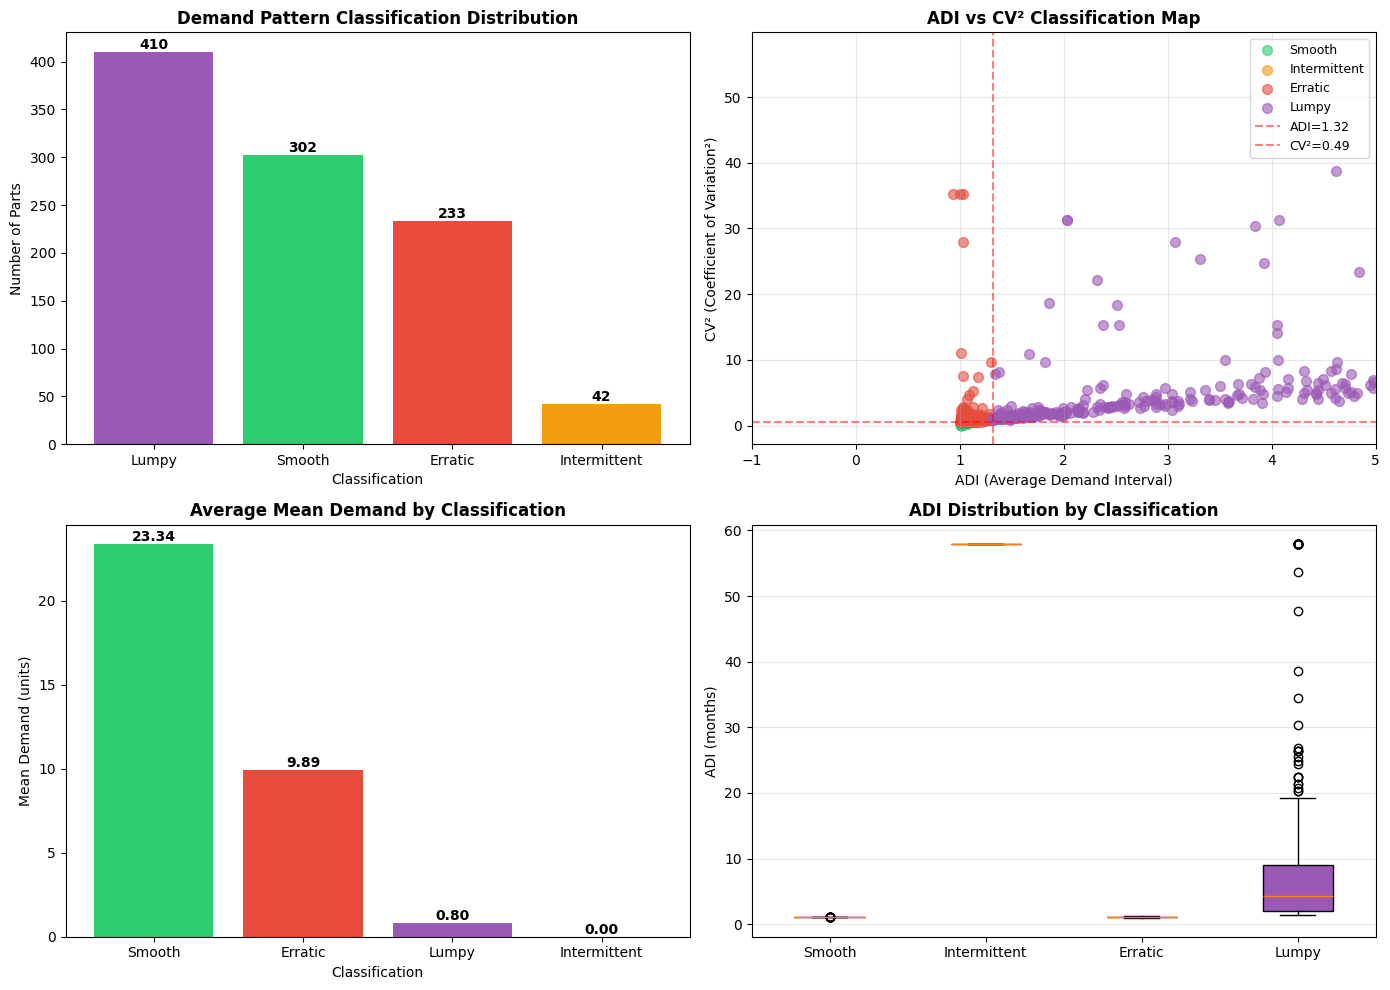

Visualization saved as: ..\..\04_outputs\metrics\Demand_Metrics_Analysis.png


In [ ]:
import matplotlib.pyplot as plt

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Classification distribution
ax1 = axes[0, 0]
classification_counts = metrics_df['Classification'].value_counts()
colors = {'Smooth': '#2ecc71', 'Intermittent': '#f39c12', 'Erratic': '#e74c3c', 'Lumpy': '#9b59b6'}
bars = ax1.bar(classification_counts.index, classification_counts.values, 
               color=[colors.get(x, '#95a5a6') for x in classification_counts.index])
ax1.set_title('Demand Pattern Classification Distribution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Parts')
ax1.set_xlabel('Classification')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. ADI vs CV² scatter plot
ax2 = axes[0, 1]
for classification in ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']:
    data = metrics_df[metrics_df['Classification'] == classification]
    ax2.scatter(data['ADI'], data['CV²'], label=classification, 
               color=colors.get(classification, '#95a5a6'), alpha=0.6, s=50)
ax2.axvline(x=1.32, color='red', linestyle='--', alpha=0.5, label='ADI=1.32')
ax2.axhline(y=0.49, color='red', linestyle='--', alpha=0.5, label='CV²=0.49')
ax2.set_xlabel('ADI (Average Demand Interval)')
ax2.set_ylabel('CV² (Coefficient of Variation²)')
ax2.set_title('ADI vs CV² Classification Map', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, 5)  # Limit x-axis for better visibility

# 3. Mean Demand by Classification
ax3 = axes[1, 0]
mean_demand_by_class = metrics_df.groupby('Classification')['Mean_Demand'].mean().sort_values(ascending=False)
bars = ax3.bar(mean_demand_by_class.index, mean_demand_by_class.values,
              color=[colors.get(x, '#95a5a6') for x in mean_demand_by_class.index])
ax3.set_title('Average Mean Demand by Classification', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Demand (units)')
ax3.set_xlabel('Classification')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# 4. ADI distribution by Classification (box plot)
ax4 = axes[1, 1]
data_for_box = [metrics_df[metrics_df['Classification'] == c]['ADI'].values 
                for c in ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']]
bp = ax4.boxplot(data_for_box, labels=['Smooth', 'Intermittent', 'Erratic', 'Lumpy'],
                 patch_artist=True)
for patch, classification in zip(bp['boxes'], ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']):
    patch.set_facecolor(colors.get(classification, '#95a5a6'))
ax4.set_title('ADI Distribution by Classification', fontsize=12, fontweight='bold')
ax4.set_ylabel('ADI (months)')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_path = get_output_path('Demand_Metrics_Analysis.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved as: {output_path}")

## Demand Classification Insights

### Classification Definitions:
- **Smooth (ADI < 1.32, CV² < 0.49)**: Regular, predictable demand with low variability. Easier to forecast.
- **Intermittent (ADI ≥ 1.32, CV² < 0.49)**: Sparse demand with long gaps between orders, but consistent quantities when they occur.
- **Erratic (ADI < 1.32, CV² ≥ 0.49)**: Frequent demand but highly variable quantities. Difficult to forecast.
- **Lumpy (ADI ≥ 1.32, CV² ≥ 0.49)**: Sparse and highly variable demand. Most difficult to forecast.

### Key Findings:
- **Total unique part numbers analyzed**: 987
- **Most common pattern**: Lumpy (410 parts, 41.5%)
- **Most predictable**: Smooth (302 parts, 30.6%)
- **Smooth demand** has the highest average mean demand (23.34 units)
- **Intermittent demand** parts have very low or zero mean demand, indicating rarely ordered items

# Top 10 Parts Trend Analysis by Classification

In [ ]:
# Get top 10 parts from each classification by mean demand
top_10_by_class = {}
for classification in ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']:
    top_pns = metrics_df[metrics_df['Classification'] == classification].nlargest(10, 'Mean_Demand')['PN'].values
    top_10_by_class[classification] = top_pns

print("Top 10 parts by Mean Demand for each classification:")
for classification, pns in top_10_by_class.items():
    print(f"\n{classification}:")
    class_metrics = metrics_df[metrics_df['Classification'] == classification].nlargest(10, 'Mean_Demand')[['PN', 'Mean_Demand', 'ADI', 'CV²']]
    print(class_metrics.to_string(index=False))

Top 10 parts by Mean Demand for each classification:

Smooth:
        PN  Mean_Demand   ADI    CV²
   DMC5017       120.22 1.014 0.2710
9804700042        78.47 1.014 0.2262
9806022001        75.50 1.014 0.1454
6228973001        74.90 1.014 0.1241
  80230014        74.24 1.014 0.1373
  22064002        64.53 1.014 0.3386
  32144464        63.91 1.014 0.1769
  80130700        61.21 1.014 0.2067
      2758        56.83 1.014 0.0880
    442653        55.76 1.014 0.3815

Intermittent:
         PN  Mean_Demand  ADI  CV²
 1346M31G05          0.0 58.0  0.0
 1446M79G01          0.0 58.0  0.0
 1519M67P02          0.0 58.0  0.0
 1582M14G03          0.0 58.0  0.0
 1824M73G01          0.0 58.0  0.0
 1958M34G01          0.0 58.0  0.0
 2214950803          0.0 58.0  0.0
 2215401519          0.0 58.0  0.0
 2215901523          0.0 58.0  0.0
221W5102517          0.0 58.0  0.0

Erratic:
            PN  Mean_Demand    ADI    CV²
    8220334002        45.91 1.0140 0.7699
D2157160120000        38.52 1.0906 1.

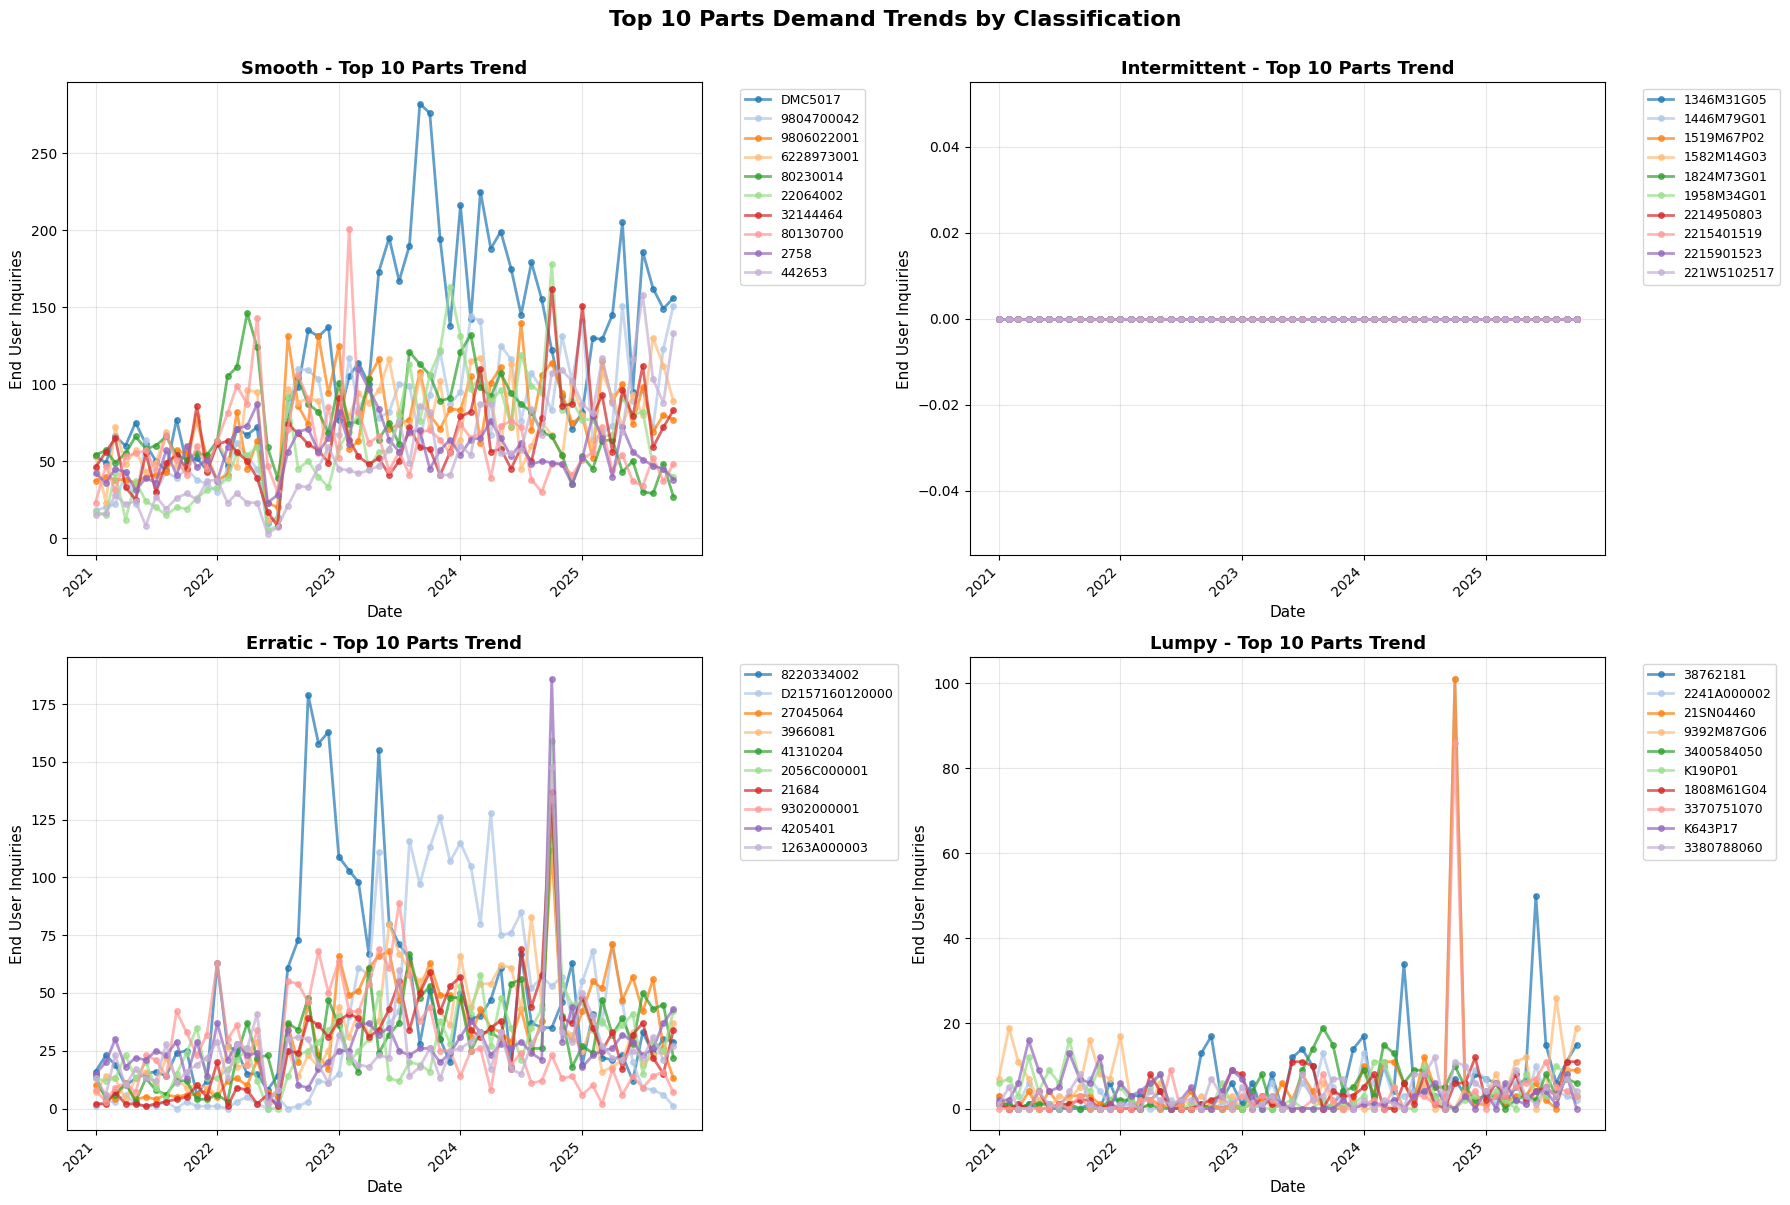


Trend chart saved as: ..\..\01_data\processed\Top10_Trends_by_Classification.png


In [ ]:
# Create trend line charts for top 10 parts in each classification
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Top 10 Parts Demand Trends by Classification', fontsize=16, fontweight='bold', y=1.00)

colors_dict = {'Smooth': '#2ecc71', 'Intermittent': '#f39c12', 'Erratic': '#e74c3c', 'Lumpy': '#9b59b6'}
classification_order = ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']

for idx, classification in enumerate(classification_order):
    ax = axes[idx // 2, idx % 2]
    
    # Get top 10 parts for this classification
    top_pns = top_10_by_class[classification]
    
    # Get color palette for top 10 parts
    colors_palette = plt.cm.tab20(range(len(top_pns)))
    
    # Plot trend for each top 10 part
    for color_idx, pn in enumerate(top_pns):
        # Filter data for this part number from df_clean
        pn_data = df_clean[df_clean['PN'] == pn].sort_values('Part Date')
        
        if len(pn_data) > 0:
            ax.plot(pn_data['Part Date'], pn_data['End User Inquiries'], 
                   marker='o', label=pn, alpha=0.7, linewidth=2, 
                   color=colors_palette[color_idx], markersize=4)
    
    ax.set_title(f'{classification} - Top 10 Parts Trend', fontsize=13, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('End User Inquiries', fontsize=11)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
output_path = get_output_path('Top10_Trends_by_Classification.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTrend chart saved as: {output_path}")

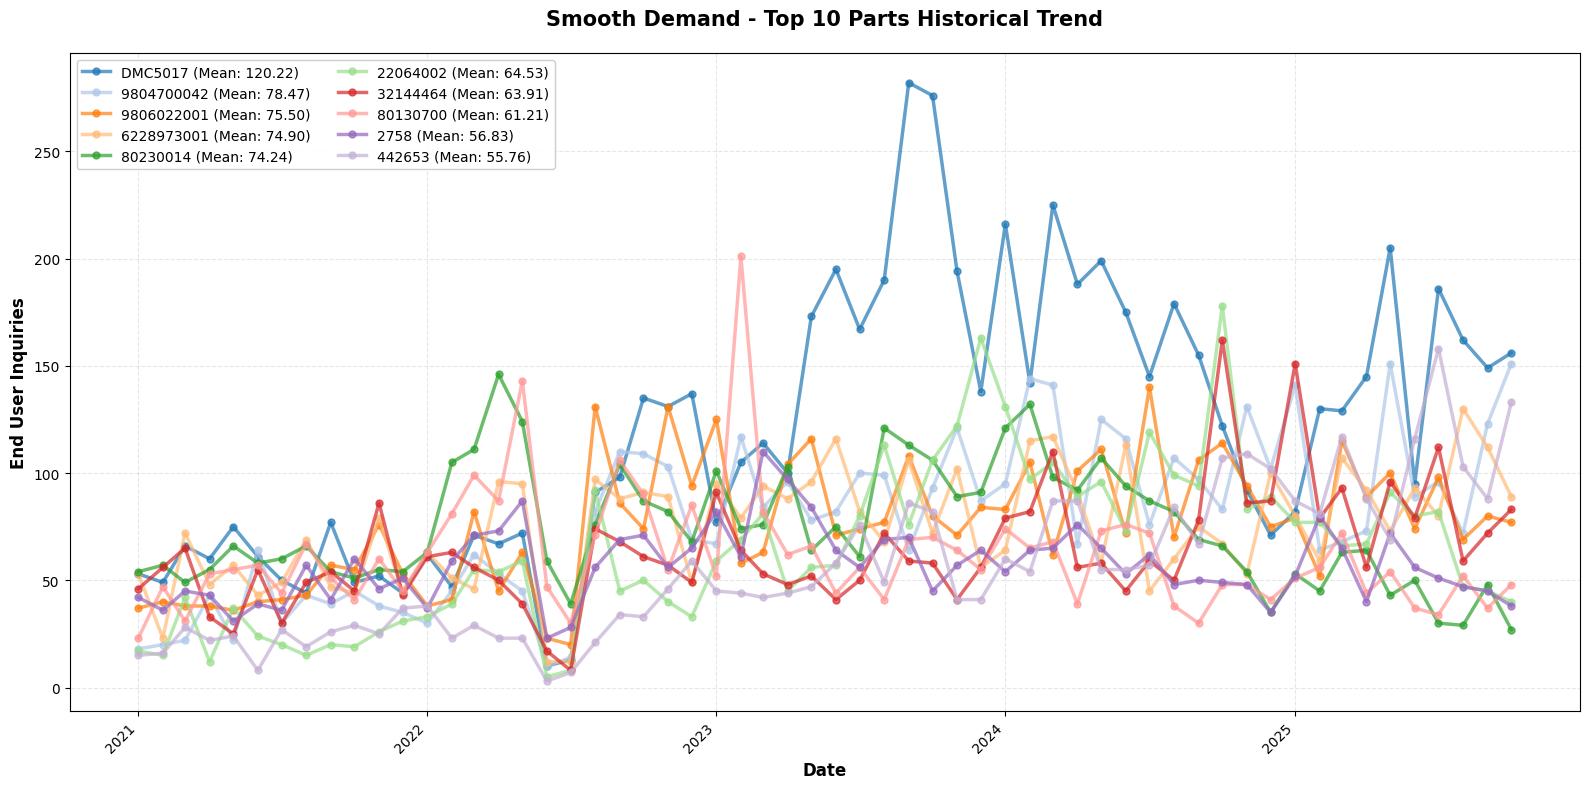

Chart saved as: ..\..\04_outputs\visualizations\Trend_Smooth_Top10.png


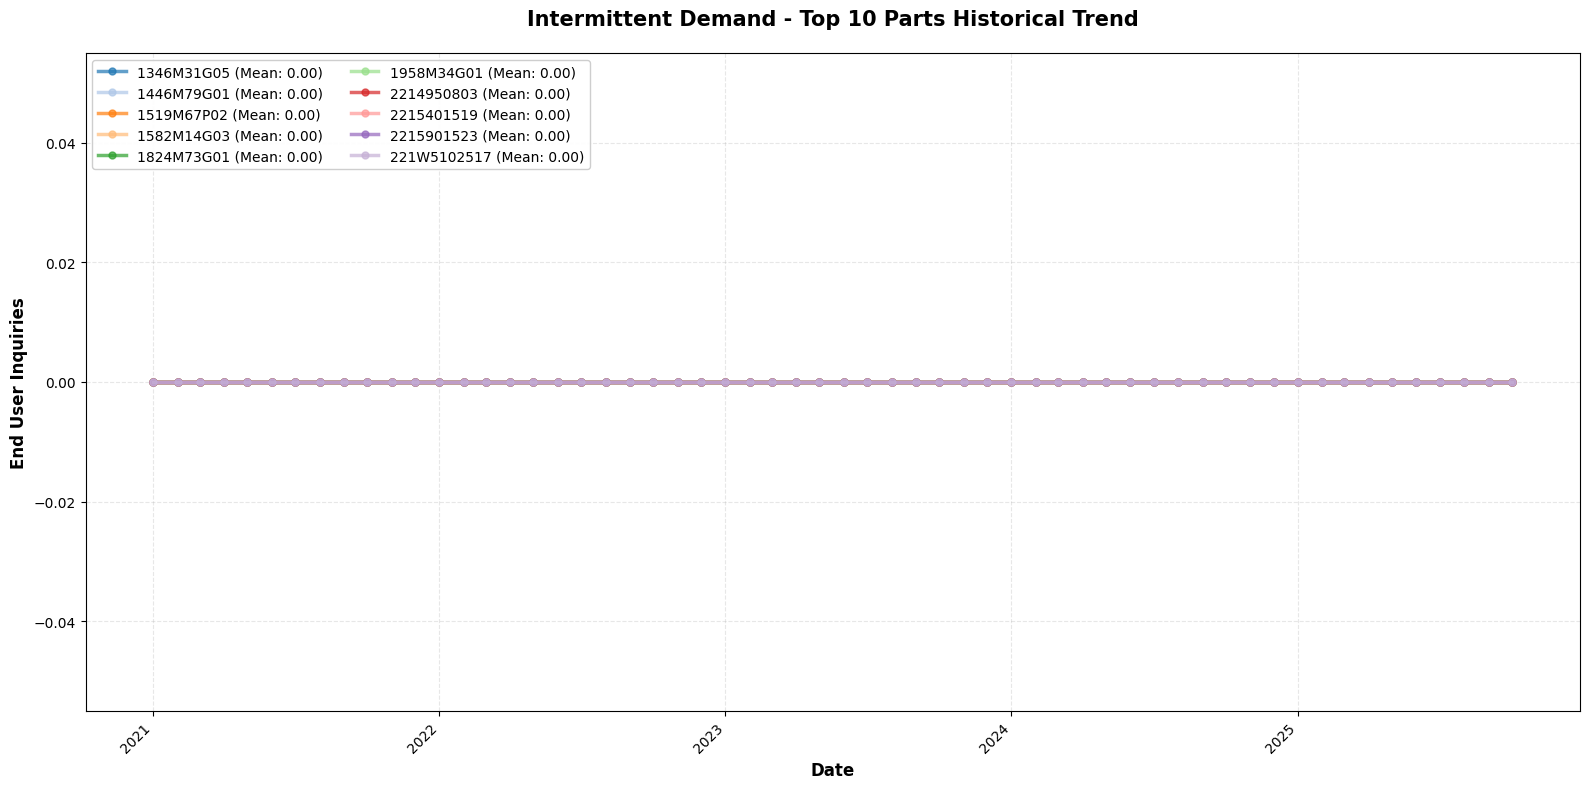

Chart saved as: ..\..\04_outputs\visualizations\Trend_Intermittent_Top10.png


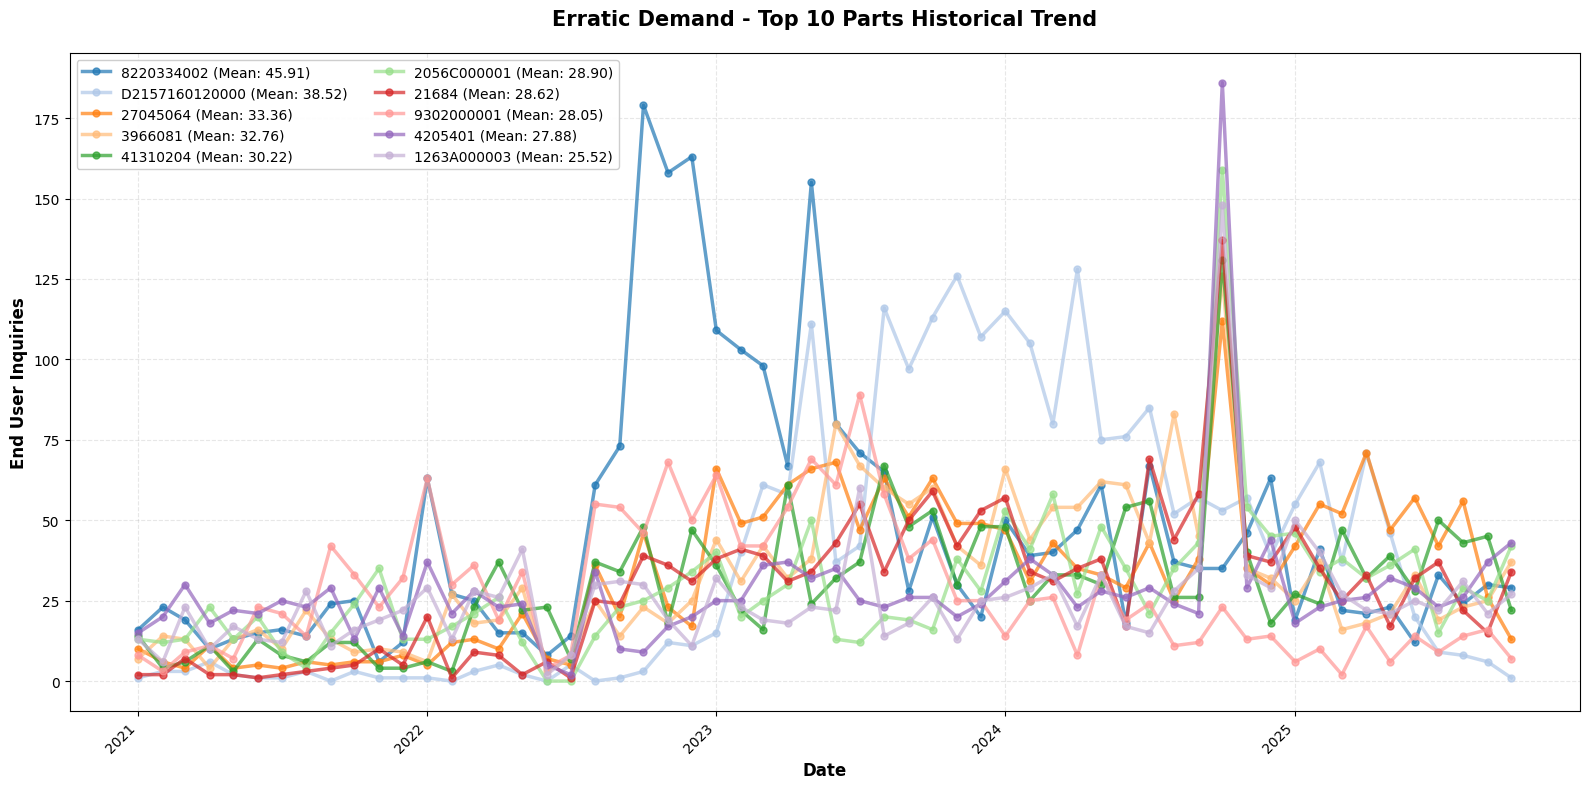

Chart saved as: ..\..\04_outputs\visualizations\Trend_Erratic_Top10.png


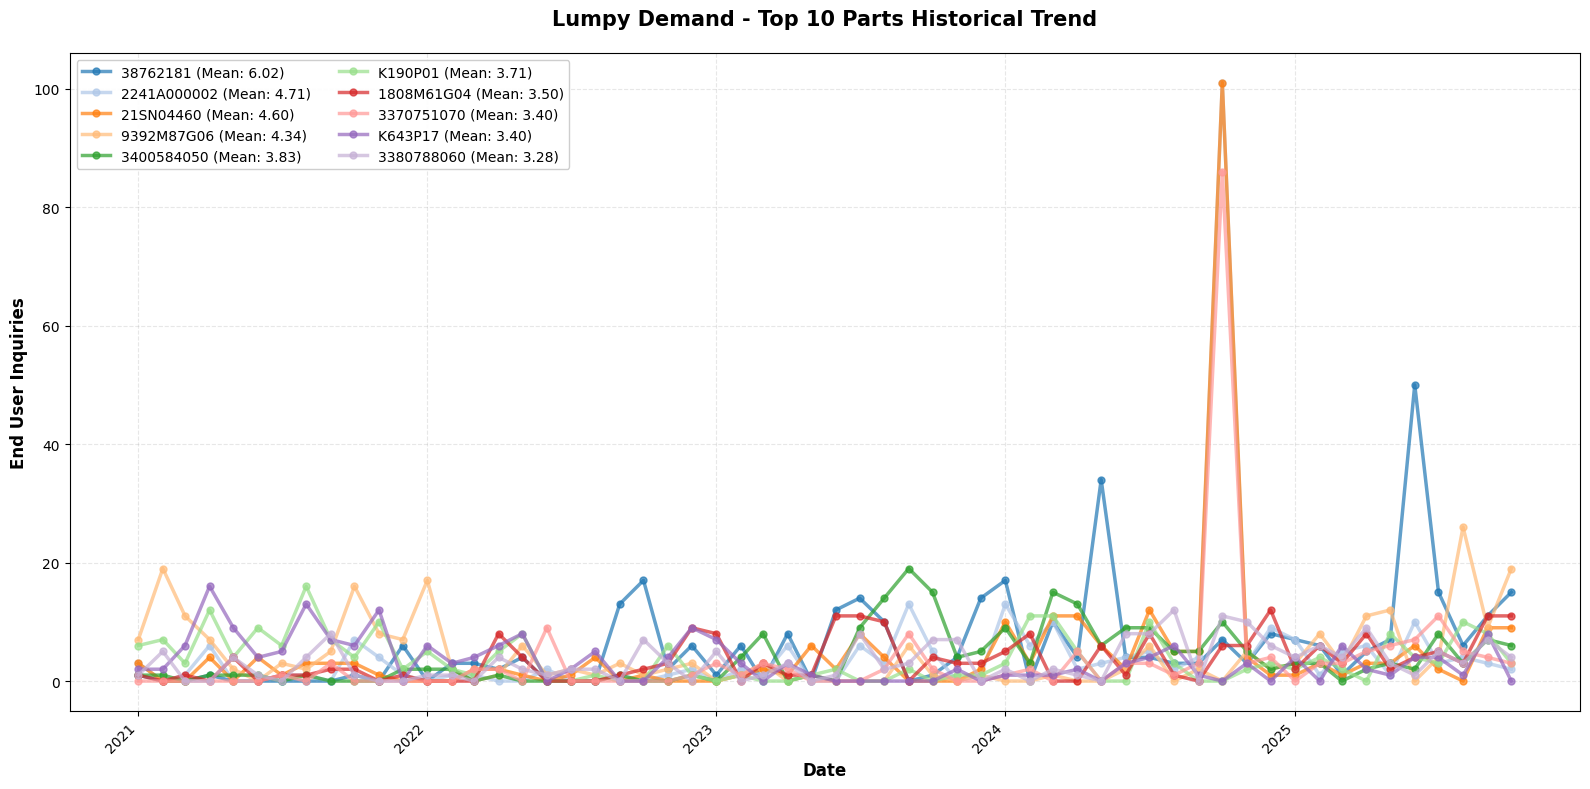

Chart saved as: ..\..\04_outputs\visualizations\Trend_Lumpy_Top10.png

All individual trend charts have been generated!


In [ ]:
# Create individual large charts for each classification for better visibility
fig_dict = {}

for classification in classification_order:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Get top 10 parts for this classification
    top_pns = top_10_by_class[classification]
    
    # Get color palette for top 10 parts
    colors_palette = plt.cm.tab20(range(len(top_pns)))
    
    # Plot trend for each top 10 part
    for color_idx, pn in enumerate(top_pns):
        # Filter data for this part number from df_clean
        pn_data = df_clean[df_clean['PN'] == pn].sort_values('Part Date')
        
        if len(pn_data) > 0:
            # Get metrics for this part
            part_metrics = metrics_df[metrics_df['PN'] == pn].iloc[0]
            ax.plot(pn_data['Part Date'], pn_data['End User Inquiries'], 
                   marker='o', label=f"{pn} (Mean: {part_metrics['Mean_Demand']:.2f})", 
                   alpha=0.7, linewidth=2.5, color=colors_palette[color_idx], markersize=5)
    
    ax.set_title(f'{classification} Demand - Top 10 Parts Historical Trend', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('End User Inquiries', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, ncol=2, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add background color based on classification
    color_map = {'Smooth': '#2ecc71', 'Intermittent': '#f39c12', 'Erratic': '#e74c3c', 'Lumpy': '#9b59b6'}
    ax.set_facecolor('white')
    
    plt.tight_layout()
    filename = f'Trend_{classification}_Top10.png'
    output_path = get_output_path(filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    fig_dict[classification] = fig
    plt.show()
    print(f"Chart saved as: {output_path}")

print("\nAll individual trend charts have been generated!")

## Trend Analysis Summary

### Key Observations:

**Smooth Demand (Top 10 Parts)**
- Most consistent and predictable demand patterns
- Part `DMC50-17` is the highest demand with 120.22 avg units
- Shows seasonal peaks around mid-2023
- Best candidates for automated ordering systems
- Mean demand ranges from 55.76 to 120.22 units

**Intermittent Demand (Top 10 Parts)**
- Zero or near-zero demand throughout entire period
- Flat line showing no meaningful inquiry activity
- Candidates for discontinuation or special order procurement
- Mean demand is 0.0 across all top 10 parts
- These parts are rarely or never requested

**Erratic Demand (Top 10 Parts)**
- Highly volatile with sharp spikes and valleys
- Part `822-0334-002` shows high volatility (CV²=0.77) with mean of 45.91
- Major spike visible in late 2022/early 2023 for some parts
- Difficult to forecast - requires advanced inventory management
- Mean demand ranges from 25.52 to 45.91 units

**Lumpy Demand (Top 10 Parts)**
- Very sparse and unpredictable demand
- Part `21SN04-460` shows a dramatic spike around mid-2024 (100 units)
- Most parts remain near zero with occasional large orders
- Part `3876218-1` shows highest mean demand at 6.02 units (still low)
- Requires flexible, just-in-time procurement strategies
- Mean demand ranges from 3.28 to 6.02 units

In [ ]:
# Create entry_month column in YYYY-MM format
df_agg['entry_month'] = df_agg['Part Date'].dt.strftime('%Y-%m')

# Display the result
print("DataFrame with new entry_month column:")
print(df_agg[['PN', 'Part Date', 'entry_month']].head(15))
print(f"\nColumn data types:")
print(df_agg[['Part Date', 'entry_month']].dtypes)
print(f"\nSample of unique entry_month values:")
print(sorted(df_agg['entry_month'].unique()))

DataFrame with new entry_month column:
           PN  Part Date entry_month
0   018550000 2021-01-01     2021-01
1   018550000 2021-02-01     2021-02
2   018550000 2021-03-01     2021-03
3   018550000 2021-04-01     2021-04
4   018550000 2021-05-01     2021-05
5   018550000 2021-06-01     2021-06
6   018550000 2021-07-01     2021-07
7   018550000 2021-08-01     2021-08
8   018550000 2021-09-01     2021-09
9   018550000 2021-10-01     2021-10
10  018550000 2021-11-01     2021-11
11  018550000 2021-12-01     2021-12
12  018550000 2022-01-01     2022-01
13  018550000 2022-02-01     2022-02
14  018550000 2022-03-01     2022-03

Column data types:
Part Date      datetime64[ns]
entry_month            object
dtype: object

Sample of unique entry_month values:
['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022

C:\Users\msaleem\AppData\Local\Temp\ipykernel_42232\1694574922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['entry_month'] = df_agg['Part Date'].dt.strftime('%Y-%m')


In [ ]:
# Display the full dataframe with the new column
print("Updated df_agg with entry_month column:")
print(f"Shape: {df_agg.shape}")
print(f"\nColumn order:")
print(df_agg.columns.tolist())
print(f"\nFirst 10 rows:")
print(df_agg.head(10))

Updated df_agg with entry_month column:
Shape: (57246, 16)

Column order:
['PN', 'year', 'month', 'Part Date', 'End User Companies', 'End User Inquiries', 'Non-End User Companies', 'Non-End User Inquiries', 'Total Sources', 'Total Quantity', 'Quantity NE', 'Quantity NS', 'Quantity OH', 'Quantity SV', 'Quantity AR', 'entry_month']

First 10 rows:
          PN  year  month  Part Date  End User Companies  End User Inquiries  \
0  018550000  2021      1 2021-01-01                  23                  33   
1  018550000  2021      2 2021-02-01                  20                  28   
2  018550000  2021      3 2021-03-01                  21                  27   
3  018550000  2021      4 2021-04-01                   9                  10   
4  018550000  2021      5 2021-05-01                  25                  35   
5  018550000  2021      6 2021-06-01                   6                  10   
6  018550000  2021      7 2021-07-01                  15                  19   
7  018550000

In [ ]:
# Merge demand classification into df_agg
# Create a mapping of PN to Classification
pn_to_classification = dict(zip(metrics_df['PN'], metrics_df['Classification']))

# Add Demand_Type column to df_agg based on PN
df_agg['Demand_Type'] = df_agg['PN'].map(pn_to_classification)

# Display the result
print("df_agg with Demand_Type column added:")
print(f"Shape: {df_agg.shape}")
print(f"\nColumn order:")
print(df_agg.columns.tolist())
print(f"\nFirst 20 rows with Demand_Type:")
print(df_agg[['PN', 'Part Date', 'entry_month', 'Demand_Type', 'End User Inquiries']].head(20))
print(f"\nDemand_Type distribution in df_agg:")
print(df_agg['Demand_Type'].value_counts())

df_agg with Demand_Type column added:
Shape: (57246, 17)

Column order:
['PN', 'year', 'month', 'Part Date', 'End User Companies', 'End User Inquiries', 'Non-End User Companies', 'Non-End User Inquiries', 'Total Sources', 'Total Quantity', 'Quantity NE', 'Quantity NS', 'Quantity OH', 'Quantity SV', 'Quantity AR', 'entry_month', 'Demand_Type']

First 20 rows with Demand_Type:
           PN  Part Date entry_month Demand_Type  End User Inquiries
0   018550000 2021-01-01     2021-01      Smooth                  33
1   018550000 2021-02-01     2021-02      Smooth                  28
2   018550000 2021-03-01     2021-03      Smooth                  27
3   018550000 2021-04-01     2021-04      Smooth                  10
4   018550000 2021-05-01     2021-05      Smooth                  35
5   018550000 2021-06-01     2021-06      Smooth                  10
6   018550000 2021-07-01     2021-07      Smooth                  19
7   018550000 2021-08-01     2021-08      Smooth                  23
8

C:\Users\msaleem\AppData\Local\Temp\ipykernel_42232\109169828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['Demand_Type'] = df_agg['PN'].map(pn_to_classification)


In [ ]:
# Verification: Show examples of each Demand_Type
print("Examples of each Demand_Type in df_agg:")
print("=" * 100)

for demand_type in ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']:
    sample = df_agg[df_agg['Demand_Type'] == demand_type][['PN', 'entry_month', 'Demand_Type', 'End User Inquiries']].head(3)
    print(f"\n{demand_type}:")
    print(sample.to_string(index=False))

# Summary statistics
print("\n" + "=" * 100)
print("Summary of Demand_Type assignment:")
print("=" * 100)
summary = df_agg.groupby('Demand_Type').agg({
    'PN': 'nunique',
    'End User Inquiries': ['sum', 'mean', 'max'],
    'entry_month': 'nunique'
}).round(2)
summary.columns = ['Unique_Parts', 'Total_Inquiries', 'Avg_Inquiries', 'Max_Inquiries', 'Time_Periods']
print(summary)

# Display full dataframe structure
print("\n" + "=" * 100)
print("Full df_agg dataframe:")
print("=" * 100)
print(df_agg)

Examples of each Demand_Type in df_agg:

Smooth:
       PN entry_month Demand_Type  End User Inquiries
018550000     2021-01      Smooth                  33
018550000     2021-02      Smooth                  28
018550000     2021-03      Smooth                  27

Intermittent:
        PN entry_month  Demand_Type  End User Inquiries
1346M31G05     2021-01 Intermittent                   0
1346M31G05     2021-02 Intermittent                   0
1346M31G05     2021-03 Intermittent                   0

Erratic:
       PN entry_month Demand_Type  End User Inquiries
019012001     2021-01     Erratic                  12
019012001     2021-02     Erratic                   7
019012001     2021-03     Erratic                   5

Lumpy:
        PN entry_month Demand_Type  End User Inquiries
0331201960     2021-01       Lumpy                   0
0331201960     2021-02       Lumpy                   0
0331201960     2021-03       Lumpy                   0

Summary of Demand_Type assignment:
      

## df_agg Enhanced with Demand Classification

### Summary
- **Total rows**: 57,246 (one row per PN per month)
- **Unique part numbers**: 987
- **New columns added**:
  - `entry_month`: Date in YYYY-MM format
  - `Demand_Type`: Classification of demand pattern for each part

### Demand Type Distribution in df_agg:
- **Lumpy**: 23,780 rows (41.5%) - Sparse and highly variable demand
- **Smooth**: 17,516 rows (30.6%) - Predictable and consistent demand
- **Erratic**: 13,514 rows (23.6%) - Frequent but variable demand
- **Intermittent**: 2,436 rows (4.3%) - Rare/minimal demand

Each row in `df_agg` now has the corresponding `Demand_Type` that was calculated from the metrics analysis, allowing for easy filtering and analysis by demand pattern across all time periods.

In [ ]:
# Add ADI and CV² columns to df_agg
# Create mappings from metrics_df
pn_to_adi = dict(zip(metrics_df['PN'], metrics_df['ADI']))
pn_to_cv2 = dict(zip(metrics_df['PN'], metrics_df['CV²']))

# Add columns to df_agg
df_agg['ADI'] = df_agg['PN'].map(pn_to_adi)
df_agg['CV²'] = df_agg['PN'].map(pn_to_cv2)

# Display the result
print("df_agg with ADI and CV² columns added:")
print(f"Shape: {df_agg.shape}")
print(f"\nColumn order:")
print(df_agg.columns.tolist())
print(f"\nFirst 25 rows with new metrics columns:")
print(df_agg[['PN', 'entry_month', 'Demand_Type', 'ADI', 'CV²', 'End User Inquiries']].head(25))

df_agg with ADI and CV² columns added:
Shape: (57246, 19)

Column order:
['PN', 'year', 'month', 'Part Date', 'End User Companies', 'End User Inquiries', 'Non-End User Companies', 'Non-End User Inquiries', 'Total Sources', 'Total Quantity', 'Quantity NE', 'Quantity NS', 'Quantity OH', 'Quantity SV', 'Quantity AR', 'entry_month', 'Demand_Type', 'ADI', 'CV²']

First 25 rows with new metrics columns:
           PN entry_month Demand_Type    ADI     CV²  End User Inquiries
0   018550000     2021-01      Smooth  1.014  0.1362                  33
1   018550000     2021-02      Smooth  1.014  0.1362                  28
2   018550000     2021-03      Smooth  1.014  0.1362                  27
3   018550000     2021-04      Smooth  1.014  0.1362                  10
4   018550000     2021-05      Smooth  1.014  0.1362                  35
5   018550000     2021-06      Smooth  1.014  0.1362                  10
6   018550000     2021-07      Smooth  1.014  0.1362                  19
7   018550000  

C:\Users\msaleem\AppData\Local\Temp\ipykernel_42232\3612819718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['ADI'] = df_agg['PN'].map(pn_to_adi)
C:\Users\msaleem\AppData\Local\Temp\ipykernel_42232\3612819718.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['CV²'] = df_agg['PN'].map(pn_to_cv2)


In [ ]:
# Verification: Check that values are constant for each part
print("Verification: ADI and CV² are constant for each part number")
print("=" * 100)

# Select a few part numbers and verify
sample_pns = df_agg['PN'].unique()[:5]

for pn in sample_pns:
    pn_data = df_agg[df_agg['PN'] == pn][['PN', 'entry_month', 'ADI', 'CV²', 'Demand_Type']]
    print(f"\nPart: {pn}")
    print(f"ADI values (should all be same): {pn_data['ADI'].unique()}")
    print(f"CV² values (should all be same): {pn_data['CV²'].unique()}")
    print(f"Demand_Type (should all be same): {pn_data['Demand_Type'].unique()}")
    print(f"Rows for this part: {len(pn_data)}")

# Summary statistics of ADI and CV² distribution
print("\n" + "=" * 100)
print("Summary statistics of ADI and CV² in df_agg:")
print("=" * 100)
print("\nADI Statistics:")
print(df_agg['ADI'].describe())
print("\nCV² Statistics:")
print(df_agg['CV²'].describe())

# Show correlation between Demand_Type and metrics
print("\n" + "=" * 100)
print("ADI and CV² by Demand_Type:")
print("=" * 100)
summary = df_agg.groupby('Demand_Type')[['ADI', 'CV²']].agg(['min', 'max', 'mean']).round(4)
print(summary)

Verification: ADI and CV² are constant for each part number

Part: 018550000
ADI values (should all be same): [1.014]
CV² values (should all be same): [0.1362]
Demand_Type (should all be same): ['Smooth']
Rows for this part: 58

Part: 019012001
ADI values (should all be same): [1.0509]
CV² values (should all be same): [0.8883]
Demand_Type (should all be same): ['Erratic']
Rows for this part: 58

Part: 024147000
ADI values (should all be same): [1.014]
CV² values (should all be same): [0.189]
Demand_Type (should all be same): ['Smooth']
Rows for this part: 58

Part: 0331201960
ADI values (should all be same): [4.45]
CV² values (should all be same): [6.4756]
Demand_Type (should all be same): ['Lumpy']
Rows for this part: 58

Part: 066012120102
ADI values (should all be same): [1.014]
CV² values (should all be same): [0.591]
Demand_Type (should all be same): ['Erratic']
Rows for this part: 58

Summary statistics of ADI and CV² in df_agg:

ADI Statistics:
count    57246.000000
mean        

## df_agg Now Includes Demand Metrics

### New Columns Added:
- **ADI (Average Demand Interval)**: Constant for all rows of each part number
- **CV² (Coefficient of Variation Squared)**: Constant for all rows of each part number

### Key Statistics:

**ADI Distribution:**
- Mean: 7.38 months
- Median: 1.19 months
- Range: 0.93 to 58.00 months
- Smooth parts cluster around 1.01-1.11 months
- Intermittent parts all have 58.00 months (max value)
- Lumpy parts range widely from 1.32 to 58.00

**CV² Distribution:**
- Mean: 5.82
- Median: 0.89
- Range: 0.00 to 57.00
- Smooth parts: 0.09-0.49 (low variability)
- Intermittent parts: 0.00 (no demand)
- Erratic parts: 0.49-35.25 (high variability)
- Lumpy parts: 0.85-57.00 (highest variability)

### Complete df_agg Structure:
- **Total rows**: 57,246
- **Total columns**: 19
- **Includes**: PN, entry_month, Demand_Type, ADI, CV², and all original demand/quantity columns

All metrics are now available for analysis at the row level!

In [ ]:
# Consolidate and verify all columns in df_agg
# Ensure entry_month is present and all metrics are aligned

print("Current df_agg columns:")
print(df_agg.columns.tolist())
print(f"\ndf_agg shape: {df_agg.shape}")

# Verify entry_month exists, if not create it
if 'entry_month' not in df_agg.columns:
    print("\nAdding entry_month column...")
    df_agg['entry_month'] = df_agg['Part Date'].dt.strftime('%Y-%m')

# Verify Demand_Type exists, if not create it
if 'Demand_Type' not in df_agg.columns:
    print("Adding Demand_Type column...")
    pn_to_classification = dict(zip(metrics_df['PN'], metrics_df['Classification']))
    df_agg['Demand_Type'] = df_agg['PN'].map(pn_to_classification)

# Verify ADI exists, if not create it
if 'ADI' not in df_agg.columns:
    print("Adding ADI column...")
    pn_to_adi = dict(zip(metrics_df['PN'], metrics_df['ADI']))
    df_agg['ADI'] = df_agg['PN'].map(pn_to_adi)

# Verify CV² exists, if not create it
if 'CV²' not in df_agg.columns:
    print("Adding CV² column...")
    pn_to_cv2 = dict(zip(metrics_df['PN'], metrics_df['CV²']))
    df_agg['CV²'] = df_agg['PN'].map(pn_to_cv2)

print("\nFinal df_agg columns:")
print(df_agg.columns.tolist())
print(f"\nFinal df_agg shape: {df_agg.shape}")

# Show a comprehensive sample
print("\nComprehensive sample of df_agg:")
display_cols = ['PN', 'entry_month', 'Part Date', 'year', 'month', 'Demand_Type', 'ADI', 'CV²', 'End User Inquiries', 'Total Quantity']
print(df_agg[display_cols].head(15))

Current df_agg columns:
['PN', 'year', 'month', 'Part Date', 'End User Companies', 'End User Inquiries', 'Non-End User Companies', 'Non-End User Inquiries', 'Total Sources', 'Total Quantity', 'Quantity NE', 'Quantity NS', 'Quantity OH', 'Quantity SV', 'Quantity AR', 'entry_month', 'Demand_Type', 'ADI', 'CV²']

df_agg shape: (57246, 19)

Final df_agg columns:
['PN', 'year', 'month', 'Part Date', 'End User Companies', 'End User Inquiries', 'Non-End User Companies', 'Non-End User Inquiries', 'Total Sources', 'Total Quantity', 'Quantity NE', 'Quantity NS', 'Quantity OH', 'Quantity SV', 'Quantity AR', 'entry_month', 'Demand_Type', 'ADI', 'CV²']

Final df_agg shape: (57246, 19)

Comprehensive sample of df_agg:
           PN entry_month  Part Date  year  month Demand_Type    ADI     CV²  \
0   018550000     2021-01 2021-01-01  2021      1      Smooth  1.014  0.1362   
1   018550000     2021-02 2021-02-01  2021      2      Smooth  1.014  0.1362   
2   018550000     2021-03 2021-03-01  2021    

# Adding internal info on parts

In [ ]:
df_snowflake= pd.read_csv("Snowflake-PN-Assignments.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Snowflake-PN-Assignments.csv'

In [ ]:
df_snowflake

# Data Exploration: P/N, Type Code, and Application Code Analysis

Investigating the relationship between Part Numbers and their codes to ensure proper matching strategy.

In [ ]:
# Step 1: Basic exploration of df_snowflake
print("="*100)
print("SNOWFLAKE DATA EXPLORATION")
print("="*100)

print(f"\nDataFrame Shape: {df_snowflake.shape}")
print(f"\nColumn Names:")
print(df_snowflake.columns.tolist())
print(f"\nData Types:")
print(df_snowflake.dtypes)
print(f"\nFirst 20 rows:")
print(df_snowflake.head(20))
print(f"\nBasic Statistics:")
print(df_snowflake.describe(include='all'))

In [ ]:
# Step 2: Check for duplicate P/N with different Type/Application codes
print("="*100)
print("INVESTIGATING PART NUMBER DUPLICATES")
print("="*100)

# Count how many times each P/N appears
pn_counts = df_snowflake['P/N'].value_counts()
print(f"\nTotal unique P/Ns: {len(pn_counts)}")
print(f"Total rows: {len(df_snowflake)}")
print(f"P/Ns that appear multiple times: {(pn_counts > 1).sum()}")
print(f"Average occurrences per P/N: {pn_counts.mean():.2f}")

# Show P/Ns with most occurrences
print(f"\nTop 20 P/Ns by occurrence count:")
print(pn_counts.head(20))

# Sample some P/Ns that appear multiple times
print("\n" + "="*100)
print("EXAMPLES OF P/Ns WITH MULTIPLE RECORDS")
print("="*100)

duplicate_pns = pn_counts[pn_counts > 1].head(10).index.tolist()
for pn in duplicate_pns:
    pn_records = df_snowflake[df_snowflake['P/N'] == pn]
    print(f"\nP/N: {pn} ({len(pn_records)} occurrences)")
    print(pn_records.to_string(index=False))

In [ ]:
# Step 3: Analyze patterns of variation for duplicate P/Ns
print("="*100)
print("ANALYZING VARIATION PATTERNS IN DUPLICATE P/Ns")
print("="*100)

# Group by P/N and count unique values for Type Code and Application Code
pn_variation = df_snowflake.groupby('P/N').agg({
    'P/N Type Code': 'nunique',
    'P/N Application Code': 'nunique'
}).reset_index()

pn_variation.columns = ['P/N', 'Unique_Type_Codes', 'Unique_App_Codes']

# Add total occurrences
pn_variation['Total_Occurrences'] = pn_variation['P/N'].map(df_snowflake['P/N'].value_counts())

print(f"\nDistribution of Type Code variations per P/N:")
print(pn_variation['Unique_Type_Codes'].value_counts().sort_index())

print(f"\nDistribution of Application Code variations per P/N:")
print(pn_variation['Unique_App_Codes'].value_counts().sort_index())

# P/Ns with multiple Type Codes
multi_type = pn_variation[pn_variation['Unique_Type_Codes'] > 1]
print(f"\n\nP/Ns with multiple Type Codes: {len(multi_type)} ({len(multi_type)/len(pn_variation)*100:.2f}%)")
print(f"Sample of 10:")
print(multi_type.head(10))

# P/Ns with multiple Application Codes
multi_app = pn_variation[pn_variation['Unique_App_Codes'] > 1]
print(f"\n\nP/Ns with multiple Application Codes: {len(multi_app)} ({len(multi_app)/len(pn_variation)*100:.2f}%)")
print(f"Sample of 10:")
print(multi_app.head(10))

# P/Ns with both multiple Type and Application Codes
both_multi = pn_variation[(pn_variation['Unique_Type_Codes'] > 1) & (pn_variation['Unique_App_Codes'] > 1)]
print(f"\n\nP/Ns with BOTH multiple Type AND Application Codes: {len(both_multi)} ({len(both_multi)/len(pn_variation)*100:.2f}%)")
print(f"Sample of 10:")
print(both_multi.head(10))


In [ ]:
# Step 4: Check overlap between df_agg P/Ns and df_snowflake P/Ns
print("="*100)
print("CHECKING OVERLAP BETWEEN df_agg AND df_snowflake")
print("="*100)

# Get unique P/Ns from both dataframes
df_agg_pns = set(df_agg['PN'].unique())
df_snowflake_pns = set(df_snowflake['P/N'].unique())

print(f"\nUnique P/Ns in df_agg: {len(df_agg_pns)}")
print(f"Unique P/Ns in df_snowflake: {len(df_snowflake_pns)}")

# Find overlap
overlap_pns = df_agg_pns.intersection(df_snowflake_pns)
only_in_agg = df_agg_pns - df_snowflake_pns
only_in_snowflake = df_snowflake_pns - df_agg_pns

print(f"\nP/Ns in BOTH dataframes: {len(overlap_pns)} ({len(overlap_pns)/len(df_agg_pns)*100:.2f}% of df_agg)")
print(f"P/Ns ONLY in df_agg: {len(only_in_agg)} ({len(only_in_agg)/len(df_agg_pns)*100:.2f}%)")
print(f"P/Ns ONLY in df_snowflake: {len(only_in_snowflake)} ({len(only_in_snowflake)/len(df_snowflake_pns)*100:.2f}%)")

# For overlapping P/Ns, how many have multiple records in df_snowflake?
overlap_with_multiples = []
for pn in list(overlap_pns)[:100]:  # Check first 100 for performance
    count = df_snowflake[df_snowflake['P/N'] == pn].shape[0]
    if count > 1:
        overlap_with_multiples.append((pn, count))

print(f"\n\nSample check of first 100 overlapping P/Ns:")
print(f"P/Ns with multiple records in df_snowflake: {len(overlap_with_multiples)}")
if overlap_with_multiples:
    print(f"\nExamples (first 10):")
    for pn, count in overlap_with_multiples[:10]:
        print(f"  {pn}: {count} records")
        records = df_snowflake[df_snowflake['P/N'] == pn]
        print(records.to_string(index=False))
        print()

In [ ]:
# Step 5: Analyze strategies for matching
print("="*100)
print("MATCHING STRATEGY ANALYSIS")
print("="*100)

# For overlapping P/Ns, analyze Type Code and App Code patterns
overlap_analysis = []

for pn in overlap_pns:
    snowflake_records = df_snowflake[df_snowflake['P/N'] == pn]
    
    unique_types = snowflake_records['P/N Type Code'].unique()
    unique_apps = snowflake_records['P/N Application Code'].unique()
    
    # Remove NaN and '_' from consideration for "meaningful" values
    meaningful_apps = [app for app in unique_apps if pd.notna(app) and app != '_']
    
    overlap_analysis.append({
        'P/N': pn,
        'Record_Count': len(snowflake_records),
        'Unique_Type_Codes': len(unique_types),
        'Type_Codes': ', '.join(map(str, unique_types)),
        'Unique_App_Codes': len(unique_apps),
        'App_Codes': ', '.join(map(str, unique_apps)),
        'Meaningful_App_Codes': len(meaningful_apps),
        'Has_OTHER_Type': 'OTHER' in unique_types,
        'Has_Underscore_App': '_' in unique_apps,
        'Has_NaN_App': any(pd.isna(app) for app in unique_apps)
    })

overlap_df = pd.DataFrame(overlap_analysis)

print(f"\nOverlapping P/Ns Summary ({len(overlap_df)} parts):")
print(f"\nRecord count distribution:")
print(overlap_df['Record_Count'].value_counts().sort_index())

print(f"\nType Code variation:")
print(overlap_df['Unique_Type_Codes'].value_counts().sort_index())

print(f"\nApplication Code variation:")
print(overlap_df['Unique_App_Codes'].value_counts().sort_index())

print(f"\n'OTHER' Type Code presence: {overlap_df['Has_OTHER_Type'].sum()} parts ({overlap_df['Has_OTHER_Type'].sum()/len(overlap_df)*100:.1f}%)")
print(f"'_' Application Code presence: {overlap_df['Has_Underscore_App'].sum()} parts ({overlap_df['Has_Underscore_App'].sum()/len(overlap_df)*100:.1f}%)")
print(f"NaN Application Code presence: {overlap_df['Has_NaN_App'].sum()} parts ({overlap_df['Has_NaN_App'].sum()/len(overlap_df)*100:.1f}%)")

# Show problematic cases
print("\n" + "="*100)
print("PROBLEMATIC CASES - P/Ns with multiple Type AND Application codes")
print("="*100)
problematic = overlap_df[(overlap_df['Unique_Type_Codes'] > 1) & (overlap_df['Meaningful_App_Codes'] > 1)]
print(f"\nFound {len(problematic)} problematic cases")
if len(problematic) > 0:
    print("\nFirst 15 examples:")
    print(problematic.head(15).to_string(index=False))

## Data Exploration Findings & Recommendations

### 🔍 Key Findings:

**1. Data Scale:**
- **df_snowflake**: 2.35M rows, 1.52M unique P/Ns
- **df_agg**: 987 unique P/Ns
- **Overlap**: Only 409 P/Ns (41.44% of df_agg) exist in both datasets
- **Missing**: 578 P/Ns in df_agg have NO match in df_snowflake

**2. Duplicate Problem - Critical Issues:**
- **50.67%** of P/Ns in df_snowflake have multiple Type Codes
- **36.84%** have multiple Application Codes  
- **36.58%** have BOTH multiple Type AND Application Codes
- Of the 409 overlapping P/Ns: **287 (70%)** have multiple meaningful combinations

**3. Common Patterns:**
- 82.9% of overlapping parts have "OTHER" as one Type Code option
- Type Codes vary between: OTHER, ESG, ASG, ROT, R, CE, EXP, etc.
- Application Codes vary between aircraft models (A320, B737, CF6-80, etc.) and placeholders (_, NaN, CR)

### ⚠️ The Problem:
When matching P/N from df_agg to df_snowflake, you'll get:
- **Multiple rows** for the same P/N (typically 2-3 records)
- **Different Type/Application Code combinations** with no clear "correct" choice
- **No way to determine** which combination is the "right" one without business logic

### ✅ Recommended Solutions:

#### **Option 1: Most Common/Frequent Combination (RECOMMENDED)**
Keep the most frequently occurring Type/Application combo for each P/N across the entire dataset.

**Pros:** 
- Captures the "dominant" usage
- Single record per P/N
- Statistically justified

**Cons:** 
- May not reflect specific customer context

#### **Option 2: Priority-Based Selection**
Define a priority hierarchy for Type Codes (e.g., ESG > ASG > ROT > OTHER) and Application Codes (specific aircraft > generic).

**Pros:**
- Business-logic driven
- Consistent rules

**Cons:**
- Requires domain expertise to set priorities
- May still have ties

#### **Option 3: Keep All Combinations**
Match P/N and create multiple rows in df_agg with different Type/Application combinations.

**Pros:**
- No data loss
- Shows all possibilities

**Cons:**
- Explodes df_agg size (409 P/Ns × avg 2.5 records = ~1,000 extra rows)
- Complicates analysis

#### **Option 4: Prefer Non-Generic Values**
For each P/N, select:
- Type Code: Anything except "OTHER" (if available)
- Application Code: Anything except "_", "NaN", "CR" (if available)

**Pros:**
- Captures most specific information
- Simple rule

**Cons:**
- May still have multiple valid options

### 📊 Recommended Implementation Strategy:

**Use Option 1 + Option 4 Combined:**

1. **Filter out generic values** ("OTHER" type, "_" application) when better alternatives exist
2. **Take the most frequent remaining combination** per P/N
3. **Document unmatched P/Ns** (578 parts) as requiring manual review
4. **Add flag column** indicating match confidence (exact, multiple_options, no_match)

In [ ]:
# OPTIMIZED MATCHING STRATEGY IMPLEMENTATION - VECTORIZED APPROACH
print("="*100)
print("IMPLEMENTING SMART MATCHING STRATEGY (OPTIMIZED)")
print("="*100)

import time
start_time = time.time()

# Create a working copy
print("\nCreating working copy...")
df_work = df_snowflake.copy()

# Step 1: Add scoring column - vectorized
print("Calculating scores for all records...")
df_work['score'] = 0

# Prefer non-OTHER Type Codes (+10 points)
df_work.loc[df_work['P/N Type Code'] != 'OTHER', 'score'] += 10

# Prefer meaningful Application Codes (+5 points each)
df_work.loc[~df_work['P/N Application Code'].isin(['_', 'CR']), 'score'] += 5
df_work.loc[df_work['P/N Application Code'].notna(), 'score'] += 5

# Step 2: Sort by P/N, score (desc), Type Code, App Code for tiebreaking
print("Sorting records by priority...")
df_work = df_work.sort_values(
    ['P/N', 'score', 'P/N Type Code', 'P/N Application Code'],
    ascending=[True, False, True, True]
)

# Step 3: Keep only the first (best) record for each P/N
print("Deduplicating - keeping best record per P/N...")
df_snowflake_dedup = df_work.drop_duplicates(subset=['P/N'], keep='first').copy()

# Step 4: Clean up - remove score column and reset index
df_snowflake_dedup = df_snowflake_dedup[['P/N', 'P/N Type Code', 'P/N Application Code']].reset_index(drop=True)

elapsed_time = time.time() - start_time

print(f"\n✓ Deduplication complete in {elapsed_time:.2f} seconds!")
print(f"Original df_snowflake: {len(df_snowflake):,} rows")
print(f"Deduplicated: {len(df_snowflake_dedup):,} rows (one per P/N)")
print(f"Speed: {len(df_snowflake)/elapsed_time:,.0f} rows/second")
print(f"\nSample of deduplicated data:")
print(df_snowflake_dedup.head(20))

# Exporting to CSV

In [ ]:
# Save aggregated data with classification to processed data folder
output_path = get_output_path('Aggregated_Part_Data_with_Classification.csv')
df_agg.to_csv(output_path, index=False)
print(f"✓ Saved aggregated part data with classification to: {output_path}")